# Multilayer Tidal Calculations
In this cookbook we will explore how we can use TidalPy's multilayer tidal functions to calculate tidal heating as a function of radius.
Here we are using a propagation matrix technique (SVC16) that is only valid in the incompressible limit.

References:
- SVC16 : Sabadini, Vermeerson, & Cambiotti (2016, DOI: [10.1007/978-94-017-7552-6](https://doi.org/10.1007/978-94-017-7552-6).
- HH14  : Henning & Hurford (2014, DOI: [10.1088/0004-637X/789/1/30](https://doi.org/10.1088/0004-637X/789/1/30)).
- TB05  : Tobie et al. (2005), DOI: [10.1016/j.icarus.2005.04.006](https://doi.org/10.1016/j.icarus.2005.04.006).
- ID    : [IcyDwarf Code](https://github.com/MarcNeveu/IcyDwarf/blob/master/IcyDwarf/Thermal.h) written by Marc Neveu

## Build the planet

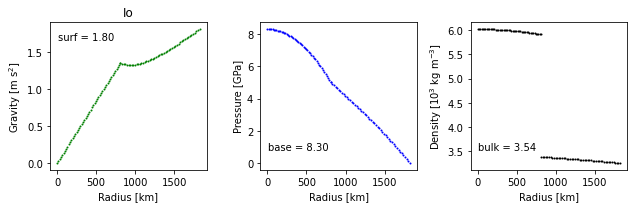

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from TidalPy import build_world
from TidalPy.utilities.numpy_helper import find_nearest
# For this example we will use the Io-Jupiter system
io = build_world('Io')
io.paint()
jupiter = build_world('Jupiter')
eccentricity = 0.0041
orbital_freq = 2. * np.pi / (86400. * 1.76914)

# We won't be using TidalPy's OOP approach (which currently does not use the multi-layer approach,
#    instead relying on a homogenous model broken up by layers), instead we will pull out a few parameters needed
#    for the multilayer calculations.
radius_array = io.radii
depth_array = (io.radius - radius_array)[::-1]
gravity_array = io.gravities
density_array = io.densities
pressure_array = io.pressures

# We will give the core and mantle a different viscoelastic state, but to do that we need to know what index
#   corresponds to the top of the core.
core_radius_cutoff = find_nearest(radius_array, io.core.radius)
mantle_N = len(radius_array[core_radius_cutoff:])
core_N = len(radius_array[:core_radius_cutoff])
total_N = len(radius_array)

# Determine some global properties
world_radius = radius_array[-1]
surface_gravity = gravity_array[-1]
mantle_bulk_density = np.average(density_array[core_radius_cutoff:])

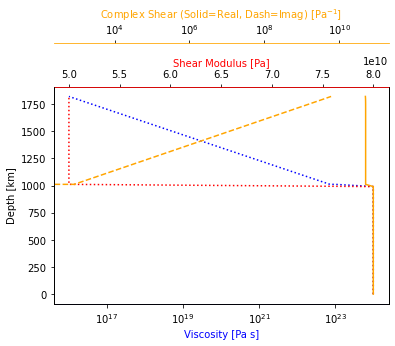

In [2]:
# Setup Io's viscoelastic state - this is not particularly accurate, just meant for demonstration purposes

# Tidal dissipation is not too sensitive to bulk modulus so we will keep it constant
bulk_moduli = 200.0e9 * np.ones_like(radius_array)
bulk_moduli[:core_radius_cutoff] = 800.0e9

# Shear modulus and viscosity is much more important, but to keep this example simple we will assume a
#   constant shear and an increasing viscosity towards the surface
shear_moduli = 50.0e9 * np.ones_like(radius_array)
shear_moduli[:core_radius_cutoff] = 80.0e9

viscosities = 1.e24 * np.ones_like(radius_array)
viscosities[core_radius_cutoff:] = np.logspace(23, 16, mantle_N)

# Now we can calculate the complex_compliance of the world. We will just use a Maxwell model here but several
#    others are available.
from TidalPy.rheology.complex_compliance.compliance_models import maxwell_array
complex_compliances = maxwell_array(orbital_freq, shear_moduli**(-1), viscosities)
# We will specifically turn off tidal dissipation in the core by setting the imaginary portion of
#    complex compliance = 0
complex_compliances[:core_radius_cutoff] = np.real(complex_compliances[:core_radius_cutoff]) + 1j * np.zeros(core_N)
complex_shears = complex_compliances**(-1)

# Now let's see what this looks like
fig_visco, ax_visco = plt.subplots()
ax_shear = ax_visco.twiny()
ax_comp = ax_visco.twiny()
ax_comp.spines["top"].set_position(("axes", 1.2))

ax_visco.plot(viscosities, depth_array/1000., c='b', ls=':')
ax_shear.plot(shear_moduli, depth_array/1000., c='r', ls=':')
ax_comp.plot(np.real(complex_shears), depth_array/1000., c='orange', ls='-')
ax_comp.plot(np.imag(complex_shears), depth_array/1000., c='orange', ls='--')

ax_visco.set(ylabel='Depth [km]', xlabel='Viscosity [Pa s]', xscale='log')
ax_shear.set(xlabel='Shear Modulus [Pa]', xscale='linear')
ax_comp.set(xlabel='Complex Shear (Solid=Real, Dash=Imag) [Pa$^{-1}$]', xscale='log')
for ax, color in zip([ax_visco, ax_shear, ax_comp], ['b', 'r', 'orange']):
    if ax is ax_visco:
        ax.spines['bottom'].set_color(color)
    else:
        ax.spines['top'].set_color(color)
    ax.xaxis.label.set_color(color)

plt.show()

In [4]:
# Load TidalPy's multilayer functions
from TidalPy.tides.multilayer import fundamental_matrix_orderl2, propagate, decompose

# Find the fundamental matrix; skip the innermost shell as that will be a boundary condition.
Y, Y_inv = fundamental_matrix_orderl2(radius_array[1:], complex_shears[1:], density_array[1:], gravity_array[1:])

# Propagate the tidal solution through the world's shells
central_boundary_condition = np.zeros((6, 3), dtype=np.complex128)
# Roberts & Nimmo (2000): Liquid innermost zone.
central_boundary_condition[2, 0] = 1.0
central_boundary_condition[3, 1] = 1.0
central_boundary_condition[5, 2] = 1.0

tidal_y = propagate(Y, Y_inv, central_boundary_condition, world_radius, order_l=2)

# Decompose the tidal solution into useful properties
radial_sensitivity_to_shear, (k2, h2, l2) = \
    decompose(tidal_y, radius_array[1:], gravity_array[1:], complex_shears[2:], bulk_moduli[2:], order_l=2)

print(f'k_2 = {k2[-1]:.2e}; h_2 = {h2[-1]:.2e}; l_2 = {l2[-1]:.2e}')

k_2 = 3.42e+12-1.19e+10j; h_2 = 1.82e+11-2.16e+10j; l_2 = 1.96e+03+5.08e+02j
